In [56]:
try:
    import procgen_tools
except ImportError:
    get_ipython().run_line_magic(
        magic_name="pip",
        line="install -U git+https://github.com/ulissemini/procgen-tools",
    )

from procgen_tools.utils import setup

setup()  # create directory structure and download data

from procgen_tools.imports import *
from procgen_tools import maze, visualization, models
from typing import Tuple, Dict, List, Optional, Union

SAVE_DIR = "playground/visualizations"
AX_SIZE = 6

cheese_channels = [7, 8, 42, 44, 55, 77, 82, 88, 89, 99, 113]
effective_channels = [8, 55, 77, 82, 88, 89, 113]

Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [2]:
venv = maze.create_venv(num=1, start_level=0, num_levels=1)
vf = visualization.vector_field(venv, hook.network)
prob = maze.geometric_probability_path((0, 0), (10, 10), vf)
print(prob)

0.4029649023327855


In [117]:
# Visualize maze, along with a heatmap of the probability of reaching
# each square
vf: Dict = visualization.vector_field(venv, hook.network)

# Make a heatmap of the probability of reaching each square
seed: int = 1
venv = maze.create_venv(num=1, start_level=seed, num_levels=1)
grid: np.ndarray = maze.get_inner_grid_from_seed(seed)
# Get cheese position
# cheese_pos: Tuple[int, int] = maze.get_cheese_pos(grid)
reachable: List[Tuple[int, int]] = maze.get_legal_mouse_positions(grid)

heatmap: np.ndarray = np.zeros_like(grid, dtype=np.float32)
for coord in reachable:
    heatmap[coord] = maze.geometric_probability_path((0, 0), coord, vf)

In [118]:
def show_grid_heatmap(
    venv: ProcgenGym3Env,
    heatmap: np.ndarray,
    ax_size: float = 3,
    mode: str = "numpy",
) -> None:
    """Show a heatmap over the maze using matplotlib.

    Args:
        venv: Vectorized environment
        heatmap: 2D array of floats
        ax_size: Size of the figure
        mode: "human" or "numpy"
    """
    env_state = maze.state_from_venv(venv, idx=0)
    inner_grid = env_state.inner_grid()
    assert inner_grid.shape == heatmap.shape
    assert mode in ("human", "numpy")

    # Create a figure
    _, ax = plt.subplots(1, 1, figsize=(ax_size, ax_size))

    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the underlying maze
    img = visualization.visualize_venv(
        venv,
        ax=ax,
        ax_size=ax_size,
        mode=mode,
        show_plot=False,
        render_padding=False,
    )

    # Plot the heatmap transparently over the maze
    from matplotlib.colors import LinearSegmentedColormap

    # Stretched heatmap
    scale_factor: float = img.shape[0] / heatmap.shape[0]
    heatmap = np.repeat(heatmap, scale_factor, axis=0)
    heatmap = np.repeat(heatmap, scale_factor, axis=1)

    # Create a custom colormap from gray to red
    colors = [(1, 0, 0, 0), (1, 0, 0, 1)]  # Gray to red
    cmap_name = "custom_div_cmap"
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    ax.imshow(heatmap[::-1], alpha=1.0, vmin=0, vmax=1, cmap=cm)

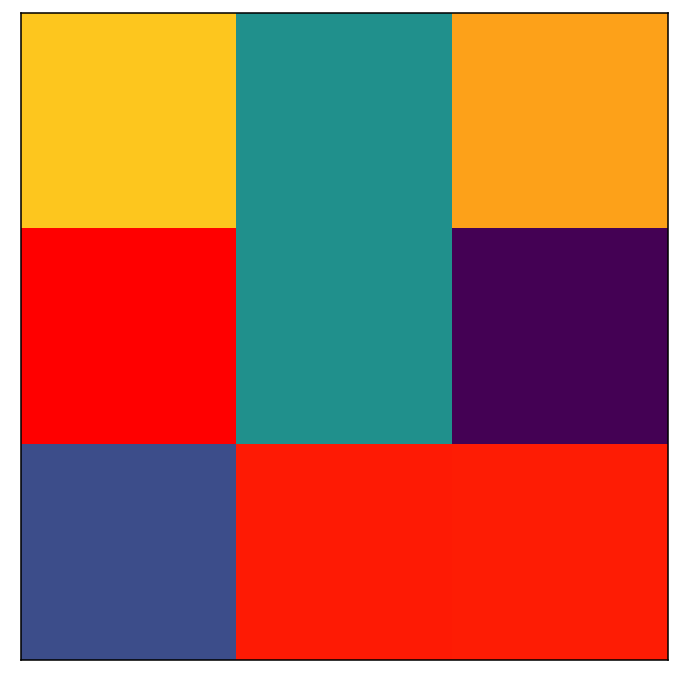

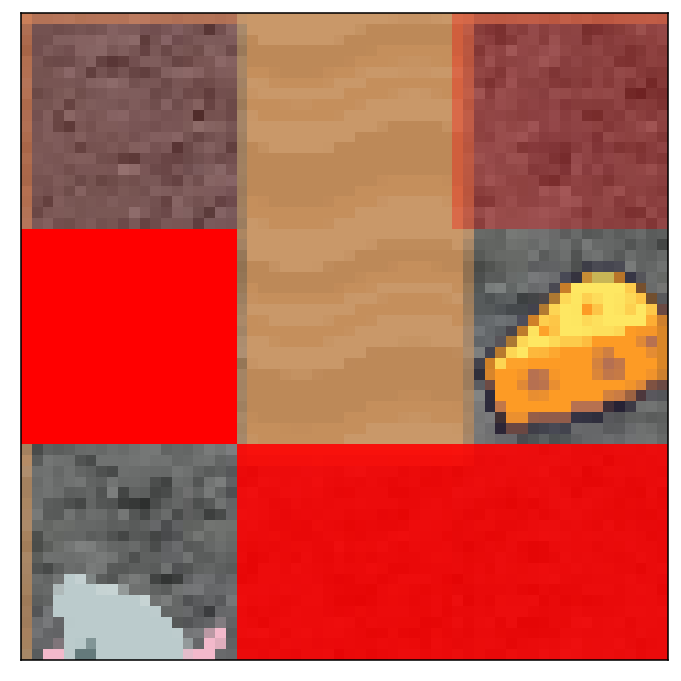

In [119]:
show_grid_heatmap(venv=venv, heatmap=heatmap, ax_size=AX_SIZE)
show_grid_heatmap(venv=venv, heatmap=heatmap, ax_size=AX_SIZE, mode="human")